# Audio sample file name classification

### Contents

1. Data analysis
2. Preprocessing data
3. Choosing performance metrics
4. Multinomial Naive Bayes
5. Random Forest Classifier
6. LSTM (Keras and Tensorflow)
7. Random Forest Classifier - using LSTM model output + numerical features
8. Model validation on unseen data

### 1. Data analysis

Data columns

- category: sample category (bass, drum, synth, vocal etc.)
- file_path (eg: BGE_13_Mid_Reece_Bass_1.wav)
- file_size (in bytes)
- duration (in miliseconds)
- sample_rate: number of sample-frames per second (in Hz)
- channels: number of audio channels (2 for stereo, 1 for mono)
- frame_count: duration * sample_rate
- sample_type: information size of a single sample-frame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import swifter
import nltk
nltk.download('punkt_tab')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

from joblib import dump, load

%matplotlib inline

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tashvit/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Check first 5 rows

In [2]:
audio_data_df = pd.read_csv('audio-file-category-data.csv')

audio_data_df.head()

,category,file_path,file_size,duration,sample_rate,channels,frame_count,sample_type
0,bass,BGE_13_Mid_Reece_Bass_1.wav,1240832,4.673016,44100,2,206080,PCM_24
1,bass,BGE_14_Mid_Reece_Bass_2.wav,1207952,4.548753,44100,2,200600,PCM_24
2,bass,BGE_15_808_Sat_Bass_1.wav,1123810,4.233061,44100,2,186678,PCM_24
3,bass,BGE_16_808_Sat_Bass_2.wav,656276,2.468413,44100,2,108857,PCM_24
4,bass,FJ_09_Bass_01.wav,701182,2.644036,44100,2,116602,PCM_24


Check number of rows, columns

In [3]:
audio_data_df.shape

(34110, 8)

Check for duplicate data rows

In [4]:
audio_data_df[audio_data_df.duplicated()]

,category,file_path,file_size,duration,sample_rate,channels,frame_count,sample_type
311,bass,DH4_10_Bass 02 C#.wav,74468,0.281270,44100,2,12404,PCM_24
333,bass,SMH_G_Syn_Bass 13.wav,239660,0.905578,44100,2,39936,PCM_24
6159,drum,CLE_Snare_8.wav,94508,0.357007,44100,2,15744,PCM_24
6176,drum,09_HConga_808.wav,25010,0.267007,44100,1,11775,PCM_16
6231,drum,SDAM_Kick_01.wav,139382,0.495238,44100,2,21840,PCM_24
...,...,...,...,...,...,...,...,...
27878,synth-loop,PLPTB_Voices_Lead_Synth_(Wet)_140_C.wav,3636206,13.714263,44100,2,604799,PCM_24
27879,synth-loop,PLPTB_Wheel_Whine_Lead_132_F#.wav,3853064,14.545442,44100,2,641454,PCM_24
27880,synth-loop,PLPTB_Window_Da_Glide_133_E.wav,3823396,14.436100,44100,2,636632,PCM_24
27881,synth-loop,PLPTB_Window_Sea_of_Blue_133_E.wav,3824964,14.436100,44100,2,636632,PCM_24


Remove duplicates

In [5]:
# Make copy of dataframe
audio_files_df = audio_data_df.copy()

audio_files_df = audio_files_df.drop_duplicates(subset=['file_path'])

audio_files_df[audio_files_df.duplicated()]

,category,file_path,file_size,duration,sample_rate,channels,frame_count,sample_type


Check new shape

In [6]:
audio_files_df.shape

(32929, 8)

In [7]:
audio_files_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32929 entries, 0 to 34109
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     32929 non-null  object 
 1   file_path    32929 non-null  object 
 2   file_size    32929 non-null  int64  
 3   duration     32929 non-null  float64
 4   sample_rate  32929 non-null  int64  
 5   channels     32929 non-null  int64  
 6   frame_count  32929 non-null  int64  
 7   sample_type  32929 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 2.3+ MB


In [8]:
audio_files_df.describe()

,file_size,duration,sample_rate,channels,frame_count
count,3.292900e+04,32929.000000,32929.000000,32929.000000,3.292900e+04
mean,2.617031e+06,10.414803,44547.808922,1.973762,4.637037e+05
std,6.131048e+06,24.170615,2815.429229,0.159846,1.072703e+06
min,3.640000e+03,0.000250,22050.000000,1.000000,1.200000e+01
25%,1.243640e+05,0.457256,44100.000000,2.000000,2.024000e+04
50%,3.840440e+05,1.714286,44100.000000,2.000000,7.717500e+04
75%,2.230166e+06,9.155283,44100.000000,2.000000,4.115040e+05
max,1.336231e+08,378.750000,192000.000000,2.000000,1.670288e+07


See the unique categories,

In [9]:
audio_files_df['category'].unique()

array(['bass', 'bass-loop', 'drum', 'drum-loop', 'effects',
       'instrumental-loops', 'instruments', 'kits-n-templates',
       'stems-n-midi', 'synth', 'synth-loop', 'vocal'], dtype=object)

In [10]:
audio_files_df['category'].nunique()

12

Checking the diversity of the 12 category groups,

In [11]:
audio_files_df.groupby('category').count()

,file_path,file_size,duration,sample_rate,channels,frame_count,sample_type
category,,,,,,,
bass,560,560,560,560,560,560,560
bass-loop,598,598,598,598,598,598,598
drum,6445,6445,6445,6445,6445,6445,6445
drum-loop,2652,2652,2652,2652,2652,2652,2652
effects,4801,4801,4801,4801,4801,4801,4801
instrumental-loops,1211,1211,1211,1211,1211,1211,1211
instruments,1237,1237,1237,1237,1237,1237,1237
kits-n-templates,2932,2932,2932,2932,2932,2932,2932
stems-n-midi,1168,1168,1168,1168,1168,1168,1168


Create a countplot of files by category

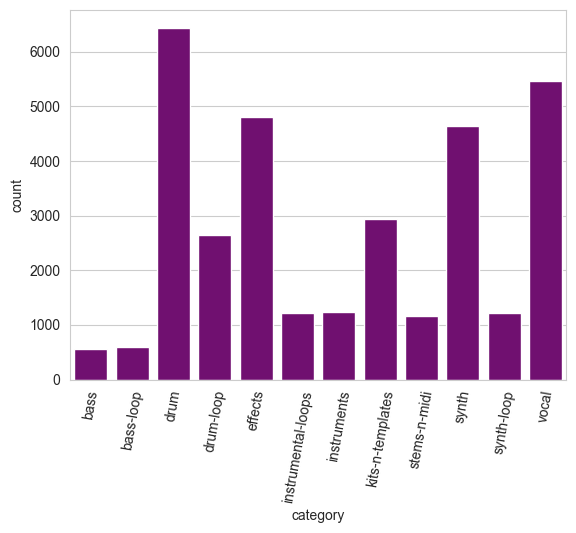

In [12]:
sns.set_style("whitegrid")
sns.countplot(data=audio_files_df, x='category', color='purple')
plt.xticks(rotation=80)
plt.show()

Due to the class imbalance, we may need to oversample minority classes or use class weights.

Checking sample types

In [13]:
audio_files_df['sample_type'].unique()

array(['PCM_24', 'PCM_16', 'FLOAT', 'MPEG_LAYER_III'], dtype=object)

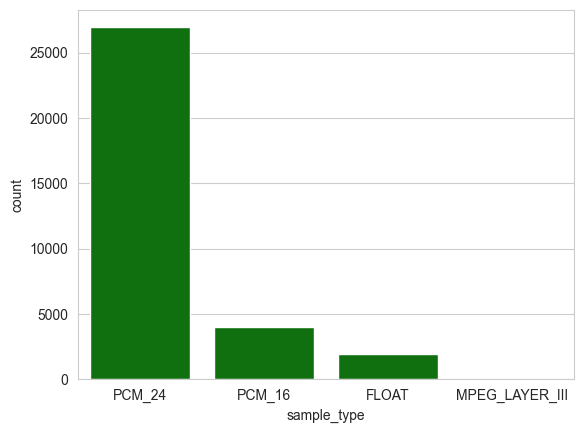

In [14]:
sns.set_style("whitegrid")
sns.countplot(data=audio_files_df, x='sample_type', color='green')
plt.show()

### 2. Preprocessing data

Convert the category and sample_type columns to numbers

In [15]:
category_mapping = {'bass': 0, 'bass-loop': 1, 'drum': 2, 'drum-loop': 3, 'effects': 4, 
           'instrumental-loops': 5, 'instruments': 6, 'kits-n-templates': 7, 
           'stems-n-midi': 8, 'synth': 9, 'synth-loop': 10, 'vocal': 11}

sample_type_mapping = {'PCM_24': 0, 'PCM_16': 1, 'FLOAT': 2, 'MPEG_LAYER_III': 3}

audio_files_df['category_num'] = audio_files_df['category'].map(category_mapping)

audio_files_df['sample_type_num'] = audio_files_df['sample_type'].map(sample_type_mapping)

audio_files_df.head()

,category,file_path,file_size,duration,sample_rate,channels,frame_count,sample_type,category_num,sample_type_num
0,bass,BGE_13_Mid_Reece_Bass_1.wav,1240832,4.673016,44100,2,206080,PCM_24,0,0
1,bass,BGE_14_Mid_Reece_Bass_2.wav,1207952,4.548753,44100,2,200600,PCM_24,0,0
2,bass,BGE_15_808_Sat_Bass_1.wav,1123810,4.233061,44100,2,186678,PCM_24,0,0
3,bass,BGE_16_808_Sat_Bass_2.wav,656276,2.468413,44100,2,108857,PCM_24,0,0
4,bass,FJ_09_Bass_01.wav,701182,2.644036,44100,2,116602,PCM_24,0,0


Create a dataframe of file names and categories

In [16]:
audio_text_df = audio_files_df[['file_path', 'category_num']]

audio_text_df.head()

,file_path,category_num
0,BGE_13_Mid_Reece_Bass_1.wav,0
1,BGE_14_Mid_Reece_Bass_2.wav,0
2,BGE_15_808_Sat_Bass_1.wav,0
3,BGE_16_808_Sat_Bass_2.wav,0
4,FJ_09_Bass_01.wav,0


Clean the file names

In [17]:
# Make copy of data
audio_filenames_df = audio_files_df.copy()

# Remove the file extension and underscores from file names
def clean_filename(file_name):
    split_filename = file_name.split('.')[0].split('_')
    # if file name end with a number, remove it
    return ' '.join(split_filename[:-1]) if split_filename[-1].isdigit() else ' '.join(split_filename)

# Using swifter to improve performance
audio_filenames_df['clean_filenames'] = audio_filenames_df['file_path'].swifter.allow_dask_on_strings(enable=True).apply(clean_filename)

audio_filenames_df.head(3)

Pandas Apply:   0%|          | 0/32929 [00:00<?, ?it/s]

,category,file_path,file_size,duration,sample_rate,channels,frame_count,sample_type,category_num,sample_type_num,clean_filenames
0,bass,BGE_13_Mid_Reece_Bass_1.wav,1240832,4.673016,44100,2,206080,PCM_24,0,0,BGE 13 Mid Reece Bass
1,bass,BGE_14_Mid_Reece_Bass_2.wav,1207952,4.548753,44100,2,200600,PCM_24,0,0,BGE 14 Mid Reece Bass
2,bass,BGE_15_808_Sat_Bass_1.wav,1123810,4.233061,44100,2,186678,PCM_24,0,0,BGE 15 808 Sat Bass


Tokenise the file names

In [18]:
audio_filenames_df['tokens'] = audio_filenames_df['clean_filenames'].swifter.allow_dask_on_strings(enable=True).apply(nltk.word_tokenize)

audio_filenames_df.head(3)

Pandas Apply:   0%|          | 0/32929 [00:00<?, ?it/s]

,category,file_path,file_size,duration,sample_rate,channels,frame_count,sample_type,category_num,sample_type_num,clean_filenames,tokens
0,bass,BGE_13_Mid_Reece_Bass_1.wav,1240832,4.673016,44100,2,206080,PCM_24,0,0,BGE 13 Mid Reece Bass,"[BGE, 13, Mid, Reece, Bass]"
1,bass,BGE_14_Mid_Reece_Bass_2.wav,1207952,4.548753,44100,2,200600,PCM_24,0,0,BGE 14 Mid Reece Bass,"[BGE, 14, Mid, Reece, Bass]"
2,bass,BGE_15_808_Sat_Bass_1.wav,1123810,4.233061,44100,2,186678,PCM_24,0,0,BGE 15 808 Sat Bass,"[BGE, 15, 808, Sat, Bass]"


Extract columns useful for machine learning

In [19]:
# Create dataframe with useful columns for machine learning
audio_data_ml = audio_filenames_df.drop(['category', 'file_path', 'sample_type', 'clean_filenames'], axis=1)

audio_data_ml.head()

,file_size,duration,sample_rate,channels,frame_count,category_num,sample_type_num,tokens
0,1240832,4.673016,44100,2,206080,0,0,"[BGE, 13, Mid, Reece, Bass]"
1,1207952,4.548753,44100,2,200600,0,0,"[BGE, 14, Mid, Reece, Bass]"
2,1123810,4.233061,44100,2,186678,0,0,"[BGE, 15, 808, Sat, Bass]"
3,656276,2.468413,44100,2,108857,0,0,"[BGE, 16, 808, Sat, Bass]"
4,701182,2.644036,44100,2,116602,0,0,"[FJ, 09, Bass]"


Remove holdout set to be used for model evaluation

In [20]:
X_all_data = audio_data_ml.drop('category_num', axis=1)
y_all_data = audio_data_ml['category_num']

# Split between seen and unseen data 
# (seen data will be used for training and validation, while unseen data can be used to test the final models)
# Data shuffled automatically
X_seen_data, X_holdout_data, y_seen_data, y_holdout_data = train_test_split(X_all_data, y_all_data, test_size=0.33, random_state=4567)

X_seen_data.shape, y_seen_data.shape, X_holdout_data.shape, y_holdout_data.shape

((22062, 7), (22062,), (10867, 7), (10867,))

Use TfidfVectorizer vectorization to create vocabularies

In [21]:
# Limiting vocabulary size to reduce computational time
MAX_VOCABULARY = 5000
CLASSES = ['bass', 'bass-loop', 'drum', 'drum-loop', 'effects', 
           'instrumental-loops', 'instruments', 'kits-n-templates', 
           'stems-n-midi', 'synth', 'synth-loop', 'vocal']

def do_nothing(x):
    return x

def baseline_vectorize(documents):
    """
    Create a vectorizer based on given training documents
    this is used for the baseline model
    :param dataframe: array of word-tokens
    :return: vectorizer
    """
    # Disable the tokenizer and preprocessor, as it was done in previous pre-processing steps
    vectorizer = TfidfVectorizer(tokenizer=do_nothing, preprocessor=do_nothing, lowercase=False, max_features=MAX_VOCABULARY)
    # Tokenize and build vocabulary
    vectorizer.fit(documents.copy())
    # Summarize
    print(sorted(vectorizer.vocabulary_)[:50]) # Only show 50 words
    print("vocabulary size =", len(vectorizer.vocabulary_))
    return vectorizer

Building vocabulary from ‘X_seen_data’

In [22]:
vectorizer = baseline_vectorize(X_seen_data['tokens'])
X = vectorizer.transform(X_seen_data['tokens'])
y = y_seen_data

['!', '#', '&', "'ll", "'m", "'re", "'s", '(', ')', '-', '-1', '-2', '-24b', '-3', '-5', '-6', '0', '00', '000', '0001', '0002', '0004', '0005', '0007', '0008', '0009', '001', '0010', '0011', '0012', '0014', '0015', '0016', '0017', '0019', '002', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '003', '0030', '0031', '0032']
vocabulary size = 5000


/Users/tashvit/Documents/GitHub/python_fun/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
X.shape, y.shape

((22062, 5000), (22062,))

Split the seen data into training and testing sets

In [24]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=6789)

# Check sizes
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((17649, 5000), (4413, 5000), (17649,), (4413,))

### 3. Choosing performance metrics

Precision is the most important metric for this multi-class classification problem, as this will minimize false positives. 

However a healthy F1-score is also desirable (a high Recall will minimize false negatives).

- True Positives 𝑘 : Instances correctly classified as class 𝑘.

- False Positives 𝑘 : Instances incorrectly classified as class 𝑘, but belong to another class.

- False Negatives 𝑘 : Instances that belong to class 𝑘 but were incorrectly classified as another class.

## Analyse performance without oversampling

The author will first analyse performance without oversampling.

If the results are poor, the author will consider oversampling minority classes or use class weights.

### 4. Multinomial Naive Bayes

In [25]:
mnb = MultinomialNB()
mnb.fit(X_train.copy(), y_train.copy())

MultinomialNB()

In [26]:
mnb_predictions = mnb.predict(X_validation)

def print_results(y_true, y_pred):
    print('Classification report')
    print(classification_report(y_true, y_pred))
    print('\n')
    
    print('Confusion matrix')
    print(confusion_matrix(y_true, y_pred))

print_results(y_validation, mnb_predictions)

Classification report
              precision    recall  f1-score   support

           0       0.94      0.27      0.42        60
           1       1.00      0.14      0.24        72
           2       0.88      0.99      0.93       894
           3       0.77      0.87      0.82       354
           4       0.88      0.94      0.91       649
           5       0.77      0.59      0.67       145
           6       0.96      0.50      0.66       161
           7       0.83      0.83      0.83       386
           8       0.80      0.67      0.73       149
           9       0.88      0.99      0.93       637
          10       0.84      0.62      0.71       149
          11       0.97      0.96      0.97       757

    accuracy                           0.88      4413
   macro avg       0.88      0.70      0.74      4413
weighted avg       0.88      0.88      0.87      4413



Confusion matrix
[[ 16   0  19   1   1   1   3   0   0  19   0   0]
 [  0  10   5  23   1   4   0  11   0   7

### 5. Random Forest Classifier 

In [27]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=14785, verbose=1)
rfc.fit(X_train.copy(), y_train.copy())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.5s finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=14785,
                       verbose=1)

In [28]:
rfc_predictions = rfc.predict(X_validation)

print_results(y_validation, rfc_predictions)

Classification report
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        60
           1       0.94      0.89      0.91        72
           2       0.97      0.97      0.97       894
           3       0.95      0.94      0.94       354
           4       0.97      0.97      0.97       649
           5       0.82      0.77      0.79       145
           6       0.94      0.72      0.81       161
           7       0.80      0.93      0.86       386
           8       0.87      0.87      0.87       149
           9       0.98      1.00      0.99       637
          10       0.91      0.85      0.88       149
          11       0.99      0.98      0.99       757

    accuracy                           0.94      4413
   macro avg       0.92      0.90      0.91      4413
weighted avg       0.95      0.94      0.94      4413



Confusion matrix
[[ 54   0   0   0   0   0   1   2   0   3   0   0]
 [  3  64   0   2   0   0   0   2   0   0

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


### 6. LSTM (with Tensorflow and Keras)

Split seen data into training and testing sets using original seen data

In [29]:
X_train, X_validation, y_train, y_validation = train_test_split(X_seen_data, y_seen_data, test_size=0.2, random_state=6789)

Function for sequence feature transformation

In [30]:
vocab_size = 500
max_length = 6
embedding_dim = 25

def create_feature_transform(texts):
    """
    Convert text to a sequence that can be used for LSTM training
    :param texts: tokens list
    :returns: input sequence padded to max_length
    """
    tokenizer = KerasTokenizer(num_words=vocab_size, oov_token='<oov>')
    tokenizer.fit_on_texts(texts)

    def transform(to_transform_text):
        sequences = tokenizer.texts_to_sequences(to_transform_text)
        # Using lstm pad_sequences function to pad the end of the sequence with shorter sequences
        # Longer sequences will be truncated
        return pad_sequences(sequences, maxlen=max_length, padding='post')
    return transform

Function to train LSTM model

In [31]:
def train_lstm_model(x_features, y_target):           
    num_classes = 12  # 0-11, inclusive
    labels = np.array(y_target)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(LSTM(units=100))
    model.add(Dense(units=num_classes, activation='softmax'))  # Softmax for mutually exclusive classes

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',  # Suitable for integer labels
                  metrics=[Precision(), Recall()])

    # Example training
    model.fit(x_features, labels, epochs=20, batch_size=1)
    return model

# Create a feature transforming function
to_features = create_feature_transform(X_train['tokens'])

# Convert text to features for training and validation
train_features = to_features(X_train['tokens'])
validation_features = to_features(X_validation['tokens'])

In [32]:
train_features.shape

(17649, 6)

Train model using the created function and save it

In [33]:
lstm_model = train_lstm_model(train_features, y_train)
lstm_model.save('lstm_model.h5')  # Save the entire model to a file

Epoch 1/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 0.8420 - precision: 0.9892 - recall: 0.0583
Epoch 2/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 0.2731 - precision: 0.9846 - recall: 0.0799
Epoch 3/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.2020 - precision: 0.9813 - recall: 0.0806
Epoch 4/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.1512 - precision: 0.9836 - recall: 0.0816
Epoch 5/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.1340 - precision: 0.9817 - recall: 0.0818
Epoch 6/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.1256 - precision: 0.9837 - recall: 0.0816
Epoch 7/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.1062 - precision: 0.9808 - recall: 0.0823
Epoch 8/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.0866 - precision: 0.9822 - recall: 0.0824
Epoch 9/20
17649/17649 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 0.0797 - precision: 0.9833 - recall: 0.0827
Epoch 10/20
17649/1

In [34]:
# Load the saved model
lstm_model = load_model('lstm_model.h5')  

Obtain the predicted classes and print results

In [35]:
# Get predicted probabilities
predicted_probabilities = lstm_model.predict(validation_features)

# Convert predicted probabilities to class labels
predicted_classes = predicted_probabilities.argmax(axis=1)

# Print classification report and confusion matrix
print_results(y_validation, predicted_classes)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        60
           1       0.86      0.86      0.86        72
           2       0.98      0.96      0.97       894
           3       0.94      0.91      0.92       354
           4       0.96      0.96      0.96       649
           5       0.85      0.87      0.86       145
           6       0.91      0.89      0.90       161
           7       0.85      0.93      0.89       386
           8       0.91      0.93      0.92       149
           9       0.98      0.98      0.98       637
          10       0.86      0.83      0.84       149
          11       0.99      0.99      0.99       757

    accuracy                           0.95      4413
   macro avg       0.92      0.92      0.92      4413
weighted avg       0.95      0.95      0.95      4413



Confusion matrix
[[ 55   1   1   0   0   0   0   1   0   2   0   0]


### 7. Random Forest Classifier - using LSTM model output + numerical features

This model uses the category probability output from the previous LSTM model with the other numerical features from the dataset.

<img src="models_diagram.png" alt="Alt text" width="700" height="200">

Getting category probability outputs for 'train_features' derived using file name tokens.

In [36]:
training_probabilities = lstm_model.predict(train_features)

# Print first probability array - 12 probability values for the 12 categories
training_probabilities[0]

552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


array([2.1760758e-11, 4.3379949e-09, 9.8595965e-10, 1.9547879e-09,
       3.0972520e-09, 1.9669439e-08, 1.3731193e-08, 8.1804269e-10,
       3.3757136e-10, 1.0000000e+00, 1.6661808e-08, 2.8434726e-09],
      dtype=float32)

Pre-process numerical data columns - normalization and standardization

In [37]:
# Check head - 6 numerical features
X_train.head()

,file_size,duration,sample_rate,channels,frame_count,sample_type_num,tokens
25864,124194,0.422925,44100,2,18651,0,"[MPS1, Synth, Shot, 323, B]"
23929,99330,0.328957,44100,2,14507,0,"[MPESS4, Synth, Shot, 088, F]"
21201,4417718,16.695669,44100,2,736279,0,"[Cymatics, -, Hairspray, -, 115, BPM, G, Maj, ..."
19428,16128448,60.952381,44100,2,2688000,0,"[WAES, Kit5, Kick, 126, Fm]"
19954,11907338,45.000000,44100,2,1984500,0,"[WALE2, Kit3, FX, Line02, 128, Gm]"


In [38]:
numerical_data_X_train = X_train.drop('tokens', axis=1).values
numerical_data_X_val = X_validation.drop('tokens', axis=1).values

# Scale the data
scaler = StandardScaler()

# Fit the scaler to the training data and transform
scaled_numerical_data_X_train = scaler.fit_transform(numerical_data_X_train)

# Save the scaler to a file with joblib
dump(scaler, 'numerical_scaler.joblib')

['numerical_scaler.joblib']

Use the same scaler on the validation data

In [39]:
# Load the saved scaler from the file
scaler = load('numerical_scaler.joblib')

# Scale the validation data without fitting
scaled_numerical_data_X_val = scaler.transform(numerical_data_X_val)

# Check first entry in scaled training data - 6 values for the 6 numerical features
scaled_numerical_data_X_train[0]

array([-0.40473935, -0.41566295, -0.15263433,  0.16540552, -0.4169775 ,
       -0.43768843])

Combine the scaled numerical features with the category probability outputs derived from text features

In [40]:
# Combined features - X train
X_train_combined_features = np.concatenate([training_probabilities, scaled_numerical_data_X_train], axis=1)

# Combined features - X validation - use predicted probabilities for X validation
X_val_combined_features = np.concatenate([predicted_probabilities, scaled_numerical_data_X_val], axis=1)

# Check first array in combined training feature 
# -> 6 numerical columns + 12 category probabilities = 18 total values
X_train_combined_features[0]

array([ 2.17607581e-11,  4.33799485e-09,  9.85959647e-10,  1.95478789e-09,
        3.09725201e-09,  1.96694394e-08,  1.37311931e-08,  8.18042689e-10,
        3.37571360e-10,  1.00000000e+00,  1.66618079e-08,  2.84347257e-09,
       -4.04739352e-01, -4.15662947e-01, -1.52634330e-01,  1.65405516e-01,
       -4.16977505e-01, -4.37688430e-01])

Create a second random forest classifier model object, fit the model and save it.

This random forest classifier model uses the previous LSTM model output and numerical features from the dataset.

In [41]:
# Random forest classifier model that uses previous LSTM model output and numerical features from the dataset
rfc_secondary = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=14785, verbose=1)

rfc_secondary.fit(X_train_combined_features.copy(), y_train.copy())

# Save the model to a file with joblib
dump(rfc_secondary, 'rfc_with_lstm_output_num_features.joblib')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished


['rfc_with_lstm_output_num_features.joblib']

Load the saved model

In [42]:
# Load the model from the file
rfc_secondary = load('rfc_with_lstm_output_num_features.joblib')

Print classification report and confusion matrix results

In [43]:
rfc_secondary_predictions = rfc_secondary.predict(X_val_combined_features)

print_results(y_validation, rfc_secondary_predictions)

Classification report
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        60
           1       0.89      0.88      0.88        72
           2       0.99      0.98      0.98       894
           3       0.95      0.93      0.94       354
           4       0.96      0.96      0.96       649
           5       0.86      0.86      0.86       145
           6       0.94      0.92      0.93       161
           7       0.92      0.95      0.94       386
           8       0.92      0.93      0.93       149
           9       0.98      0.98      0.98       637
          10       0.84      0.87      0.86       149
          11       0.99      0.99      0.99       757

    accuracy                           0.96      4413
   macro avg       0.93      0.93      0.93      4413
weighted avg       0.96      0.96      0.96      4413



Confusion matrix
[[ 56   1   1   0   0   0   0   1   0   1   0   0]
 [  0  63   0   2   0   1   0   0   1   0

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


This final attempt has produced the overall best results so far, with a F1 score of 96 and high precision. No data oversampling was necessary.

### 8. Model validation on unseen data

Validate the final model by testing against the holdout data

In [44]:
# Check head of X holdout data
X_holdout_data.head(3)

,file_size,duration,sample_rate,channels,frame_count,sample_type_num,tokens
26026,74770,0.235828,44100,2,10400,0,"[MPS2, Synth, 117, F, #]"
30730,105884,0.400000,44100,2,17640,0,"[mp1vs2, vocal, shot, 0612, d, #]"
31499,137460,0.473061,44100,2,20862,0,"[MPVGW3, Vocal, Glitch, One, Shot, 081]"


Process the unseen data so it can be used by the LSTM model

In [45]:
# Holdout data tokens - convert text to features
holdout_features = to_features(X_holdout_data['tokens'])

holdout_features.shape

(10867, 6)

Get predicted probabilities from the trained LSTM model, and combine with the scaled numerical features of the unseen data

In [46]:
# Arrays that each contain 12 probability values for the 12 categories
holdout_probabilities = lstm_model.predict(holdout_features)

# Scale the holdout data using the existing Scaler without fitting
numerical_data_X_holdout = X_holdout_data.drop('tokens', axis=1).values
scaled_numerical_data_X_holdout = scaler.transform(numerical_data_X_holdout)

# Combine the scaled numerical features with the category probability outputs
X_holdout_combined_features = np.concatenate([holdout_probabilities, scaled_numerical_data_X_holdout], axis=1)

# Check first array in combined holdout feature 
# -> 6 numerical columns + 12 category probabilities = 18 total values
X_holdout_combined_features[0]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


array([ 1.41787788e-11,  1.74825016e-10,  5.77761927e-12,  4.99887562e-11,
        1.35361067e-09,  1.15742314e-08,  1.85001459e-09,  7.77609435e-11,
        4.40123042e-11,  1.00000000e+00,  7.29537430e-10,  3.35666583e-09,
       -4.12780575e-01, -4.23497271e-01, -1.52634330e-01,  1.65405516e-01,
       -4.24747638e-01, -4.37688430e-01])

Get predictions from model and print classification report and confusion matrix results

In [47]:
predictions_unseen_data = rfc_secondary.predict(X_holdout_combined_features)

print_results(y_holdout_data, predictions_unseen_data)

Classification report
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       186
           1       0.83      0.86      0.84       203
           2       0.99      0.98      0.98      2118
           3       0.96      0.94      0.95       861
           4       0.97      0.97      0.97      1570
           5       0.85      0.84      0.84       417
           6       0.95      0.94      0.94       431
           7       0.93      0.94      0.94       982
           8       0.91      0.91      0.91       382
           9       0.98      0.98      0.98      1514
          10       0.83      0.85      0.84       399
          11       0.98      0.99      0.98      1804

    accuracy                           0.95     10867
   macro avg       0.92      0.93      0.92     10867
weighted avg       0.95      0.95      0.95     10867



Confusion matrix
[[ 174    1    2    0    0    0    0    1    0    5    1    2]
 [   3  175    0    3    1   

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


It can be seen that the model performs just about the same on unseen data, which indicates that the model is generalizing well and is not overfitting to the training data.